# Library

In [2]:
import re
import math
import string
import pickle
import geograpy
import emoji
import numpy as np
import pandas as pd
from datetime import datetime
from collections import Counter

import seaborn
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import plotly.graph_objects as go

import textstat
from lexicalrichness import LexicalRichness
from nltk.corpus import stopwords 
from nltk.tokenize import TweetTokenizer, word_tokenize
from nltk.tag import pos_tag
from textblob import TextBlob

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.ensemble import ExtraTreesClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.backend import clear_session

from utils import *

# Preprocessing

In [7]:
tweet_df = pd.read_csv('tweet_dataset_18000.csv')
user_df = pd.read_csv('user.csv')

user_df=user_df.rename(columns = {'Id':'user_id'})
author = [user_df[user_df['user_id'] == str(i[7])] for i in tweet_df.iloc[:, :].values]

user_df2 = pd.DataFrame([])
for i in author:
    user_df2=pd.concat([user_df2, i])
user_df2.reset_index()

C:\Users\Lenovo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0,6,7,8,9,11,12,13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


index              user_id                      Name         Username  \
0          0  1057960377466736641                 KogiPheoc        kogipheoc   
1          1           2221834271                     R.K.K   RonnieKarlKani   
2          2   768942845407420419               Caleb Keogh       CalebKeogh   
3          5            262062797                      SCRJ       RJM8675309   
4          6   833760307222753280      Environmental Center   greendailynews   
...      ...                  ...                       ...              ...   
17995  54645  1240290493277310978           CoronavirusTest     Covid_19Test   
17996  24277           1098373177              Chris Hallam   ChrisHallamLaw   
17997  54658            305691731  They call me gentleshaid      gentleshaid   
17998  23070           1340093874                    FWD.us            FWDus   
17999  54665           1657315094      Abdulrazak Mukhtar 😷  abdoul_official   

                       Location  \
0                          Kogi   
1                Nairobi, Kenya   
2      Scotland, United Kingdom   
3                        Canada   
4                Hackensack, NJ   
...                         ...   
17995                       NaN   
17996      Manchester | London    
17997                       NaN   
17998                       NaN   
17999                Nigeria 🇳🇬   

                                             Description  \
0      Official Twitter account of Kogi State Public ...   
1      Manchester united❤/August baby.\nOPPO PHONE PL...   
2                                   Blood Bought Truther   
3      Psychology,Criminology,published Model,Writer,...   
4      The Deirdre Imus Environmental Health Center® ...   
...                                                  ...   
17995       Find out how likely you are to have Covid-19   
17996  #Legal, political & #tech news & views for the...   
17997  Freelance Writer I Social Media Manager I Cryp...   
17998  Fixing the harmful immigration and criminal ju...   
17999  My Country First 🇳🇬 || Nigerian Current Affair...   

                                                     Url Private  \
0                                                    NaN   False   
1                                                    NaN   False   
2              https://pilgrimjustpilgrim.wordpress.com/   False   
3                                                    NaN   False   
4                 http://www.imusenvironmentalhealth.org   False   
...                                                  ...     ...   
17995                                                NaN   False   
17996         https://cms.law/en/GBR/People/Chris-HALLAM   False   
17997                    https://hive.blog/@gentleshaid/   False   
17998                                      http://FWD.us   False   
17999  https://www.linkedin.com/in/abdulrazak-mukhtar...   False   

      Follower count Following count Listed count  Created at  \
0                350              56            4  2018-11-01   
1                633             652            0  2013-12-12   
2                224             331            0  2016-08-25   
3              14642           13153           40  2011-03-07   
4                189            1134            6  2017-02-20   
...              ...             ...          ...         ...   
17995              1               0            0  2020-03-18   
17996           2330            1805          121  2013-01-17   
17997           7230            4009           33  2011-05-26   
17998          34987            1841          651  2013-04-09   
17999           4302            1757           64  2013-08-09   

      Favourites count Verified Tweet count  
0                   43    False          62  
1                 3269    False        3585  
2                  118    False         266  
3                25100    False      112438  
4                    9    False       12708  
...                ...      ..

In [8]:
add_new_col('Location', 'user_location')
add_new_col('Url', 'user_url')
add_new_col('Follower count', 'user_follower_count')
add_new_col('Following count', 'user_following_count')
add_new_col('Created at', 'user_created_at')
add_new_col('Favourites count', 'user_favourites_count')
add_new_col('Verified', 'user_verified')
add_new_col('Tweet count', 'user_tweet_count')

In [9]:
tweet_df['num_of_hashtags'] = tweet_df['Hashtags'].apply(lambda x: str(x).count(',') + 1 if str(x).strip() != 'nan' else 0)
tweet_df['num_of_mentions'] = tweet_df['Mentions'].apply(lambda x: str(x).count('@') if str(x).strip() != 'nan' else 0)
tweet_df['Date'] = tweet_df['Date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").timestamp() * 1000)
tweet_df['has_url'] = tweet_df['Urls'].apply(lambda x: '1' if str(x).strip() != 'nan' else 0)
tweet_df['has_user_url'] = tweet_df['user_url'].apply(lambda x: '1' if str(x).strip() != 'nan' else 0)
tweet_df['user_created_at'] = tweet_df['user_created_at'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").timestamp() * 1000)
tweet_df['preproc_text'] = tweet_df['Text'].apply(lambda x: preprocessing(x))

tweet_df.loc[tweet_df['Possibly sensitive'] == False, ['Possibly sensitive']] = 0
tweet_df.loc[tweet_df['Possibly sensitive'] == True, ['Possibly sensitive']] = 1
tweet_df.loc[tweet_df['Verdict'] == False, ['Verdict']] = 0
tweet_df.loc[tweet_df['Verdict'] == True, ['Verdict']] = 1
tweet_df.loc[tweet_df['user_verified'] == 'False', ['user_verified']] = 0
tweet_df.loc[tweet_df['user_verified'] == 'True', ['user_verified']] = 1

tweet_df['text_uppercase_count'] = tweet_df['preproc_text'].str.count(r'[A-Z]')
tweet_df['text_len'] = tweet_df['preproc_text'].str.len()
tweet_df['text_uppercase_percent'] = tweet_df.text_uppercase_count.div(tweet_df.text_len)
tweet_df['text_stop_words_count'] = tweet_df['preproc_text'].str.split().apply(lambda x: len(set(x) & stop_words))
tweet_df['text_word_count'] = tweet_df['preproc_text'].apply(lambda x: len(str(x).split()))
tweet_df['text_stop_words_percent'] = tweet_df['text_stop_words_count'] / tweet_df['text_word_count']

tweet_df['token'] = tweet_df.apply(lambda row: word_tokenize(row['preproc_text']), axis=1)
tweet_df['tags'] = tweet_df.apply(lambda row: pos_tag(row['token']), axis=1)
tag_count_df = pd.DataFrame(tweet_df['tags'].map(lambda x: Counter(tag[1] for tag in x)).to_list())
tag_count_df = pd.DataFrame(tweet_df['tags'].map(lambda x: Counter(tag[1] for tag in x)).to_list())
df = pd.concat([tweet_df, tag_count_df], axis=1).fillna(0).drop(['tags', 'token'], axis=1)

reading_ease, smog_index, flesch_kincaid_grade, liau_index, readability_index, dale_chall_readability_score, difficult_words, linsear_write_formula, gunning_fog, text_standard = calculate_text_statistical_features(df['Text'])
df['flesch_reading_ease'] = reading_ease
df['smog_index'] = smog_index
df['flesch_kincaid_grade'] = flesch_kincaid_grade
df['automated_readability_index'] = liau_index
df['readability_index'] = readability_index
df['dale_chall_readability_score'] = dale_chall_readability_score
df['difficult_words'] = difficult_words
df['linsear_write_formula'] = linsear_write_formula
df['gunning_fog'] = gunning_fog
df['text_standard'] = text_standard

# compute textual lexical richness measures
ttr = [LexicalRichness(doc).ttr for doc in df['Text']]
df['text_type_token_ratio'] = ttr

df['text_power_words_count'] = df['Text'].str.lower().str.count('improve|trust|immediately|discover|profit|learn|know|understand|powerful|best|win|more|bonus|exclusive|extra|you|free|health|guarantee|new|proven|safety|money|now|today|results|protect|help|easy|amazing|latest|extraordinary|how to|worst|ultimate|hot|first|big|anniversary|premiere|basic|complete|save|plus|create')
df['text_casual_words_count'] = df['Text'].str.lower().str.count('make|because|how|why|change|use|since|reason|therefore|result')
df['text_tentative_words_count'] = df['Text'].str.lower().str.count('may|might|can|could|possibly|probably|it is likely|it is unlikely|it is possible|it is probable|tends to|appears to|suggests that|seems to')
df['text_emotion_words_count'] = df['Text'].str.lower().str.count('ordeal|outrageous|provoke|repulsive|scandal|severe|shameful|shocking|terrible|tragic|unreliable|unstable|wicked|aggravate|agony|appalled|atrocious|corruption|damage|disastrous|disgusted|dreadful|eliminate|harmful|harsh|inconsiderate|enraged|offensive|aggressive|frustrated|controlling|resentful|anger|sad|fear|malicious|infuriated|critical|violent|vindictive|furious|contrary|condemning|sarcastic|poisonous|jealous|retaliating|desperate|alienated|unjustified|violated')
# https://www.joe.co.uk/life/a-definitive-ranking-of-every-swear-word-from-worst-to-best-122544
df['text_swear_words_count'] = df['Text'].str.lower().str.count('cunt|wanker|motherfucker|fuck|bastard|dick|dickhead|knob|cock|minge|pussy|punani|twat|prick|gash|clunge|snatch|fanny|tit|bellend|bollocks|bitch|jesus christ|shit|pissed|bullshit|arsehole|balls|minger|munter|bint|arse|git|bugger|sod|bloody|crap|damn|cow')

# Save the dataset

In [32]:
df.to_csv('final.csv')

# Load the final dataset

In [97]:
df = pd.read_csv('final.csv')

df['verb_count'] = df['VBZ'] + df['VBG'] + df['VBP'] + df['VBN'] + df['VBD'] + df['VB']
df['proper_noun_count'] = df['NNP'] + df['NNPS']
df['noun_count'] = df['NN'] + df['NNS']
df['pronoun_count'] = df['PRP']
df['adjective_count'] = df['JJ']

df['user_geo'] = df['user_location'].apply(lambda x: '1' if str(x).strip() != '0' else '0')

df['punctuation'] = df['Text'].apply(lambda x: len([value for value in list(x) if value in set(list(string.punctuation))]))
df['text_punctuation_percent'] = df.punctuation.div(df.text_len)

df['text_power_words_percent'] = df['text_power_words_count'] / df['text_word_count']
df['text_casual_words_percent'] = df['text_casual_words_count'] / df['text_word_count']
df['text_tentative_words_percent'] = df['text_tentative_words_count'] / df['text_word_count']
df['text_emotion_words_percent'] = df['text_emotion_words_count'] / df['text_word_count']
df['text_swear_words_percent'] = df['text_swear_words_count'] / df['text_word_count']

df['emoji_count'] = df['Text'].apply(lambda x: len(extract_emojis(str(x).strip())))
df['sentiment'] = df['Text'].apply(lambda x: TextBlob(str(x)).polarity)

df['has_reliable_source'] = df['Mentions'].apply(lambda x: str(x)[1:] in reliable_users)
df.loc[df['has_reliable_source'] == False, ['has_reliable_source']] = 0
df.loc[df['has_reliable_source'] == True, ['has_reliable_source']] = 1

labelEncoder = LabelEncoder()
df['tweet_type'] = labelEncoder.fit_transform(df['Type'].values)
df['text_standard'] = labelEncoder.fit_transform(df['text_standard'].values)

df.drop(['Unnamed: 0', 'Id', 'Time', 'Hashtags', 'Mentions', 'Urls', 'Author id', 'In reply to (user_id)', 'In response to (tweet_id)', 'Language', 'user_url', 'text_uppercase_count', 'text_len', 'text_stop_words_count', 'user_location', 'text_word_count', '.', ',', ':', '``', '$', '(', ')', "''", 'DT', 'IN', 'CC', 'EX', 'CD', 'RB', 'TO', 'WDT', 'POS', 'PDT', 'MD', 'WP', 'UH', 'RP', 'WP$', 'FW', 'LS', 'WRB', 'RBR', 'RBS', 'PRP$', 'SYM', 'JJR', 'JJS', 'VBZ', 'VBG', 'VBP', 'VBN', 'VBD', 'VB', 'NNP', 'NNPS', 'NN', 'NNS', 'PRP', 'JJ', 'text_power_words_count', 'text_casual_words_count', 'text_tentative_words_count', 'text_emotion_words_count', 'text_swear_words_count', 'Type', 'punctuation'], axis=1, inplace=True)

In [98]:
# Fill inf values
col = ['text_power_words_percent', 'text_casual_words_percent', 'text_tentative_words_percent', 'text_punctuation_percent']
for a in col:
    for j, i in enumerate(df[a]):
        if math.isinf(i):
            df.at[j, a] = 0

In [99]:
df.text_power_words_percent.fillna(np.float64(0), inplace=True)
df.text_casual_words_percent.fillna(np.float64(0), inplace=True)
df.text_tentative_words_percent.fillna(np.float64(0), inplace=True)
df.text_emotion_words_percent.fillna(np.float64(0), inplace=True)
df.text_swear_words_percent.fillna(np.float64(0), inplace=True)
df.head()

Date                                               Text  \
0  1.549485e+12  Kogi state DSNO meeting is ongoing @kogipheoc ...   
1  1.571690e+12  How true is this @ItsMutai\n#Nairobi\n#UnaiOut...   
2  1.579898e+12  A ‘High-Level Exercise’ Conducted 3 Months Ago...   
3  1.580330e+12  Coronavirus Bioweapon - How China Stole Corona...   
4  1.580330e+12  Eugenicist Bill Gates co-hosted a “high-level ...   

   Retweet count  Like count  Possibly sensitive  Verdict  \
0              0           2                   0        0   
1              0           2                   0        0   
2              0           0                   0        0   
3              1           1                   0        0   
4              6           6                   0        0   

   user_follower_count  user_following_count  user_created_at  \
0                  350                    56     1.541018e+12   
1                  633                   652     1.386794e+12   
2                  224                   331     1.472067e+12   
3                14642                 13153     1.299443e+12   
4                  189                  1134     1.487536e+12   

   user_favourites_count  user_verified  user_tweet_count  num_of_hashtags  \
0                     43              0                62                0   
1                   3269              0              3585                3   
2                    118              0               266                0   
3                  25100              0            112438                0   
4                      9              0             12708                0   

   num_of_mentions  has_url  has_user_url  \
0                1        0             0   
1                1        0             0   
2                1        1             1   
3                0        1             0   
4                0        1             1   

                                        preproc_text  text_uppercase_percent  \
0  Kogi state DSNO meeting is ongoing. The State ...                0.127660   
1  How true is this Nairobi UnaiOut KOTLoyals Fro...                0.063241   
2  A ‘ High-Level Exercise ’ Conducted 3 Months A...                0.142857   
3  Coronavirus Bioweapon - How China Stole Corona...                0.142857   
4  Eugenicist Bill Gates co-hosted a “ high-level...                0.025641   

   text_stop_words_percent  flesch_reading_ease  smog_index  \
0                 0.181818                40.01         9.5   
1                 0.108108                32.91         0.0   
2                 0.000000                25.80         0.0   
3                 0.000000                 7.52         0.0   
4                 0.307692                19.71         0.0   

   flesch_kincaid_grade  automated_readability_index  readability_index  \
0                   9.2                        12.98               11.6   
1                  18.1                        19.79               27.9   
2                  14.6                        19.84               20.4   
3                  15.4                        26.90               24.2   
4                  17.0                        19.61               23.6   

   dale_chall_readability_score  difficult_words  linsear_write_formula  \
0                          8.54                7                  3.375   
1                         12.17               16                 13.000   
2                          8.58                5                 17.000   
3                          9.14                4                 10.500   
4                         10.39                9                 22.000   

   gunning_fog  text_standard  text_type_token_ratio  verb_count  \
0         9.07             46               0.925926         4.0   
1        19.41             12               0.789474        11.0   
2        18.00             12               0.952381         2.0   
3        11.35              3               0.937500      

In [145]:
df.to_csv('Checkovid - Covid19 Fake News in Twitter.csv')

In [96]:
# a = 'text_punctuation_percent'
# print('number of inf: {}'.format(np.isinf(df[a]).values.sum()))
# print('contain NaN: {}'.format(df[a].isnull().values.any()))

# Feature selection

## Approach 1. Chi-square (Categorical Input, Categorical Output)

In [89]:
df_X = df[['Possibly sensitive', 'user_verified', 'has_url', 'has_user_url', 'text_standard', 'tweet_type', 'user_geo']]
col = list(df_X)
X = df_X.values
y = df['Verdict'].values
df_X.head(1)

Possibly sensitive  user_verified  has_url  has_user_url  text_standard  \
0                   0              0        0             0             46   

   tweet_type user_geo  
0           2        1

In [9]:
# Feature extraction
test = SelectKBest(score_func=chi2, k=4)
fit = test.fit(X, y)

# Summarize scores
np.set_printoptions(precision=3)
print(len(fit.scores_))
print(fit.scores_)

features = fit.transform(X)
# Summarize selected features
print(features[0:5,:])

6
[8.868e+01 9.374e+01 2.525e+03 2.414e+02 4.431e+03 1.552e-01]
[[ 0  0  0 46]
 [ 0  0  0 12]
 [ 0  1  1 12]
 [ 0  1  0  3]
 [ 0  1  1  9]]


In [10]:
sorted(list(zip(fit.scores_, col)), reverse=True)

[(4431.373188118363, 'text_standard'),
 (2524.6527393136666, 'has_url'),
 (241.43212907751666, 'has_user_url'),
 (93.7447216890595, 'user_verified'),
 (88.68078175895765, 'Possibly sensitive'),
 (0.15523301961673658, 'tweet_type')]

## Approach 2. ANOVA (Numerical Input, Categorical Output)

In [11]:
df_X = df.drop(['Text', 'Date', 'Possibly sensitive', 'user_created_at', 'Verdict', 'user_verified', 'has_url', 'has_user_url', 'preproc_text', 'text_standard', 'tweet_type'], axis=1)
col = list(df_X)
X = df_X.values
y = df['Verdict'].values
df_X.head(1)

Retweet count  Like count  user_follower_count  user_following_count  \
0              0           2                  350                    56   

   user_favourites_count  user_tweet_count  num_of_hashtags  num_of_mentions  \
0                     43                62                0                1   

   text_uppercase_percent  text_stop_words_percent  flesch_reading_ease  \
0                 0.12766                 0.181818                40.01   

   smog_index  flesch_kincaid_grade  automated_readability_index  \
0         9.5                   9.2                        12.98   

   readability_index  dale_chall_readability_score  difficult_words  \
0               11.6                          8.54                7   

   linsear_write_formula  gunning_fog  text_type_token_ratio  verb_count  \
0                  3.375         9.07               0.925926         4.0   

   proper_noun_count  noun_count  pronoun_count  adjective_count  \
0               12.0         3.0            0.0              0.0   

   text_power_words_percent  text_casual_words_percent  \
0                       0.0                        0.0   

   text_tentative_words_percent  text_emotion_words_percent  \
0                           0.0                         0.0   

   text_swear_words_percent  emoji_count  
0                       0.0            0

In [12]:
# Feature extraction
test = SelectKBest(score_func=f_classif, k=10)
fit = test.fit(X, y)

# Summarize scores
np.set_printoptions(precision=3)
print(len(fit.scores_))
print(fit.scores_)

features = fit.transform(X)
# Summarize selected features
print(features[0:5,:])

31
[5.353e+01 5.500e+01 3.400e+01 4.576e+01 1.985e+02 2.376e+02 3.012e+02
 9.161e+01 4.976e+02 1.789e+03 8.369e+02 2.794e+02 1.290e+02 1.390e+03
 4.499e+02 1.062e+03 1.355e+02 3.663e+01 8.028e+01 1.458e+03 1.778e+03
 6.380e+02 2.772e+03 8.511e+02 1.449e+03 4.587e+02 4.371e+01 4.218e-02
 2.958e+00 1.040e+01 3.194e+01]
[[ 0.182 40.01  12.98   8.54   0.926  4.    12.     3.     0.     0.   ]
 [ 0.108 32.91  19.79  12.17   0.789 11.     8.    10.     0.     3.   ]
 [ 0.    25.8   19.84   8.58   0.952  2.     9.     2.     0.     1.   ]
 [ 0.     7.52  26.9    9.14   0.938  2.     8.     0.     1.     0.   ]
 [ 0.308 19.71  19.61  10.39   0.875  4.     5.     3.     1.     5.   ]]


In [13]:
sorted(list(zip(fit.scores_, col)), reverse=True)

[(2771.845087044628, 'noun_count'),
 (1789.0019335531372, 'text_stop_words_percent'),
 (1778.3187383406193, 'verb_count'),
 (1457.6339753340046, 'text_type_token_ratio'),
 (1449.0396366911002, 'adjective_count'),
 (1390.1291485393376, 'automated_readability_index'),
 (1062.2020604738304, 'dale_chall_readability_score'),
 (851.0827112234446, 'pronoun_count'),
 (836.9099414736596, 'flesch_reading_ease'),
 (637.9699601649546, 'proper_noun_count'),
 (497.5787603180024, 'text_uppercase_percent'),
 (458.69236208168815, 'text_power_words_percent'),
 (449.9440316150382, 'readability_index'),
 (301.1573218135688, 'num_of_hashtags'),
 (279.4385609847264, 'smog_index'),
 (237.64727598167926, 'user_tweet_count'),
 (198.46482350953258, 'user_favourites_count'),
 (135.49958829927803, 'difficult_words'),
 (128.96546075831418, 'flesch_kincaid_grade'),
 (91.61220593241693, 'num_of_mentions'),
 (80.28479730180003, 'gunning_fog'),
 (55.003521251784775, 'Like count'),
 (53.529844617124034, 'Retweet count'

## Approach 3. Recursive Feature Elimination

In [110]:
df_X = df.drop(['Text', 'Date', 'user_created_at', 'Verdict', 'preproc_text'], axis=1)
col = list(df_X)
X = df_X.values
y = df['Verdict'].values
df_X.head(1)

sc_x = StandardScaler()
X_sc = sc_x.fit_transform(X)

model = RandomForestClassifier()
rfe = RFE(model, 20)
fit = rfe.fit(X_sc, y)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))

sorted(list(zip(fit.ranking_, col)))

Num Features: 20
Selected Features: [ True  True False  True False  True False  True False False  True False
  True  True False False False  True  True  True False  True  True False
  True  True  True  True False False False  True  True False False False
 False False  True False False]
Feature Ranking: [ 1  1 22  1  4  1 14  1  9  3  1 10  1  1  2 17  7  1  1  1  6  1  1  8
  1  1  1  1 13  5 20  1  1 11 12 16 21 18  1 19 15]


[(1, 'Like count'),
 (1, 'Retweet count'),
 (1, 'automated_readability_index'),
 (1, 'has_reliable_source'),
 (1, 'sentiment'),
 (1, 'has_url'),
 (1, 'num_of_mentions'),
 (1, 'noun_count'),
 (1, 'proper_noun_count'),
 (1, 'num_of_hashtags'),
 (1, 'text_standard'),
 (1, 'text_power_words_percent'),
 (1, 'text_punctuation_percent'),
 (1, 'text_stop_words_percent'),
 (1, 'text_type_token_ratio'),
 (1, 'text_uppercase_percent'),
 (1, 'user_favourites_count'),
 (1, 'user_follower_count'),
 (1, 'user_tweet_count'),
 (1, 'verb_count'),
 (2, 'flesch_reading_ease'),
 (3, 'linsear_write_formula'),
 (4, 'user_following_count'),
 (5, 'adjective_count'),
 (6, 'difficult_words'),
 (7, 'flesch_kincaid_grade'),
 (8, 'text_standard'),
 (9, 'num_of_hashtags'),
 (10, 'has_user_url'),
 (11, 'text_casual_words_percent'),
 (12, 'text_tentative_words_percent'),
 (13, 'pronoun_count'),
 (14, 'user_verified'),
 (15, 'tweet_type'),
 (16, 'text_emotion_words_percent'),
 (17, 'smog_index'),
 (18, 'emoji_count'),


### Approach 4. Feature Importance

[0.03  0.03  0.002 0.024 0.017 0.019 0.03  0.019 0.016 0.028 0.187 0.02
 0.031 0.039 0.02  0.007 0.018 0.029 0.024 0.026 0.022 0.024 0.026 0.022
 0.034 0.031 0.035 0.047 0.016 0.032 0.03  0.016 0.014 0.01  0.005 0.008
 0.014]


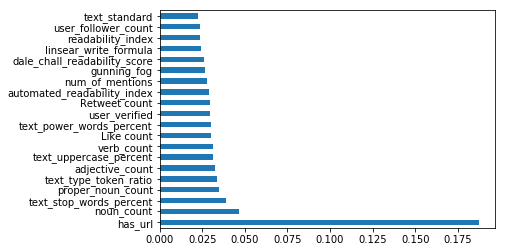

In [19]:
model = ExtraTreesClassifier()
model.fit(X_sc,y)
print(model.feature_importances_) 
feat_importances = pd.Series(model.feature_importances_, index=col)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

# Learning the data

In [148]:
['Like count', 'Retweet count', 'has_reliable_source', 'text_standard', 'has_url', 'linsear_write_formula', 'noun_count', 'proper_noun_count', 'automated_readability_index', 'sentiment', 'text_power_words_percent', 'text_punctuation_percent', 'text_stop_words_percent', 'text_type_token_ratio', 'text_uppercase_percent', 'user_favourites_count', 'user_follower_count', 'user_tweet_count', 'verb_count', 'num_of_hashtags']

['Like count',
 'Retweet count',
 'has_reliable_source',
 'text_standard',
 'has_url',
 'linsear_write_formula',
 'noun_count',
 'proper_noun_count',
 'automated_readability_index',
 'sentiment',
 'text_power_words_percent',
 'text_punctuation_percent',
 'text_stop_words_percent',
 'text_type_token_ratio',
 'text_uppercase_percent',
 'user_favourites_count',
 'user_follower_count',
 'user_tweet_count',
 'verb_count',
 'num_of_hashtags']

In [114]:
# X = df[['text_stop_words_percent', 'noun_count', 'text_type_token_ratio', 'verb_count', 'text_standard', 'has_url', 'adjective_count', 'automated_readability_index', 'dale_chall_readability_score', 'pronoun_count', 'flesch_reading_ease', 'proper_noun_count', 'text_uppercase_percent', 'text_power_words_percent', 'readability_index', 'num_of_hashtags', 'smog_index', 'user_tweet_count', 'num_of_mentions', 'Retweet count', 'flesch_kincaid_grade', 'gunning_fog']]
X = df[['Like count', 'Retweet count', 'has_reliable_source', 'text_standard', 'has_url', 'linsear_write_formula', 'noun_count', 'proper_noun_count', 'automated_readability_index', 'sentiment', 'text_power_words_percent', 'text_punctuation_percent', 'text_stop_words_percent', 'text_type_token_ratio', 'text_uppercase_percent', 'user_favourites_count', 'user_follower_count', 'user_tweet_count', 'verb_count', 'num_of_hashtags']]
y = df['Verdict']

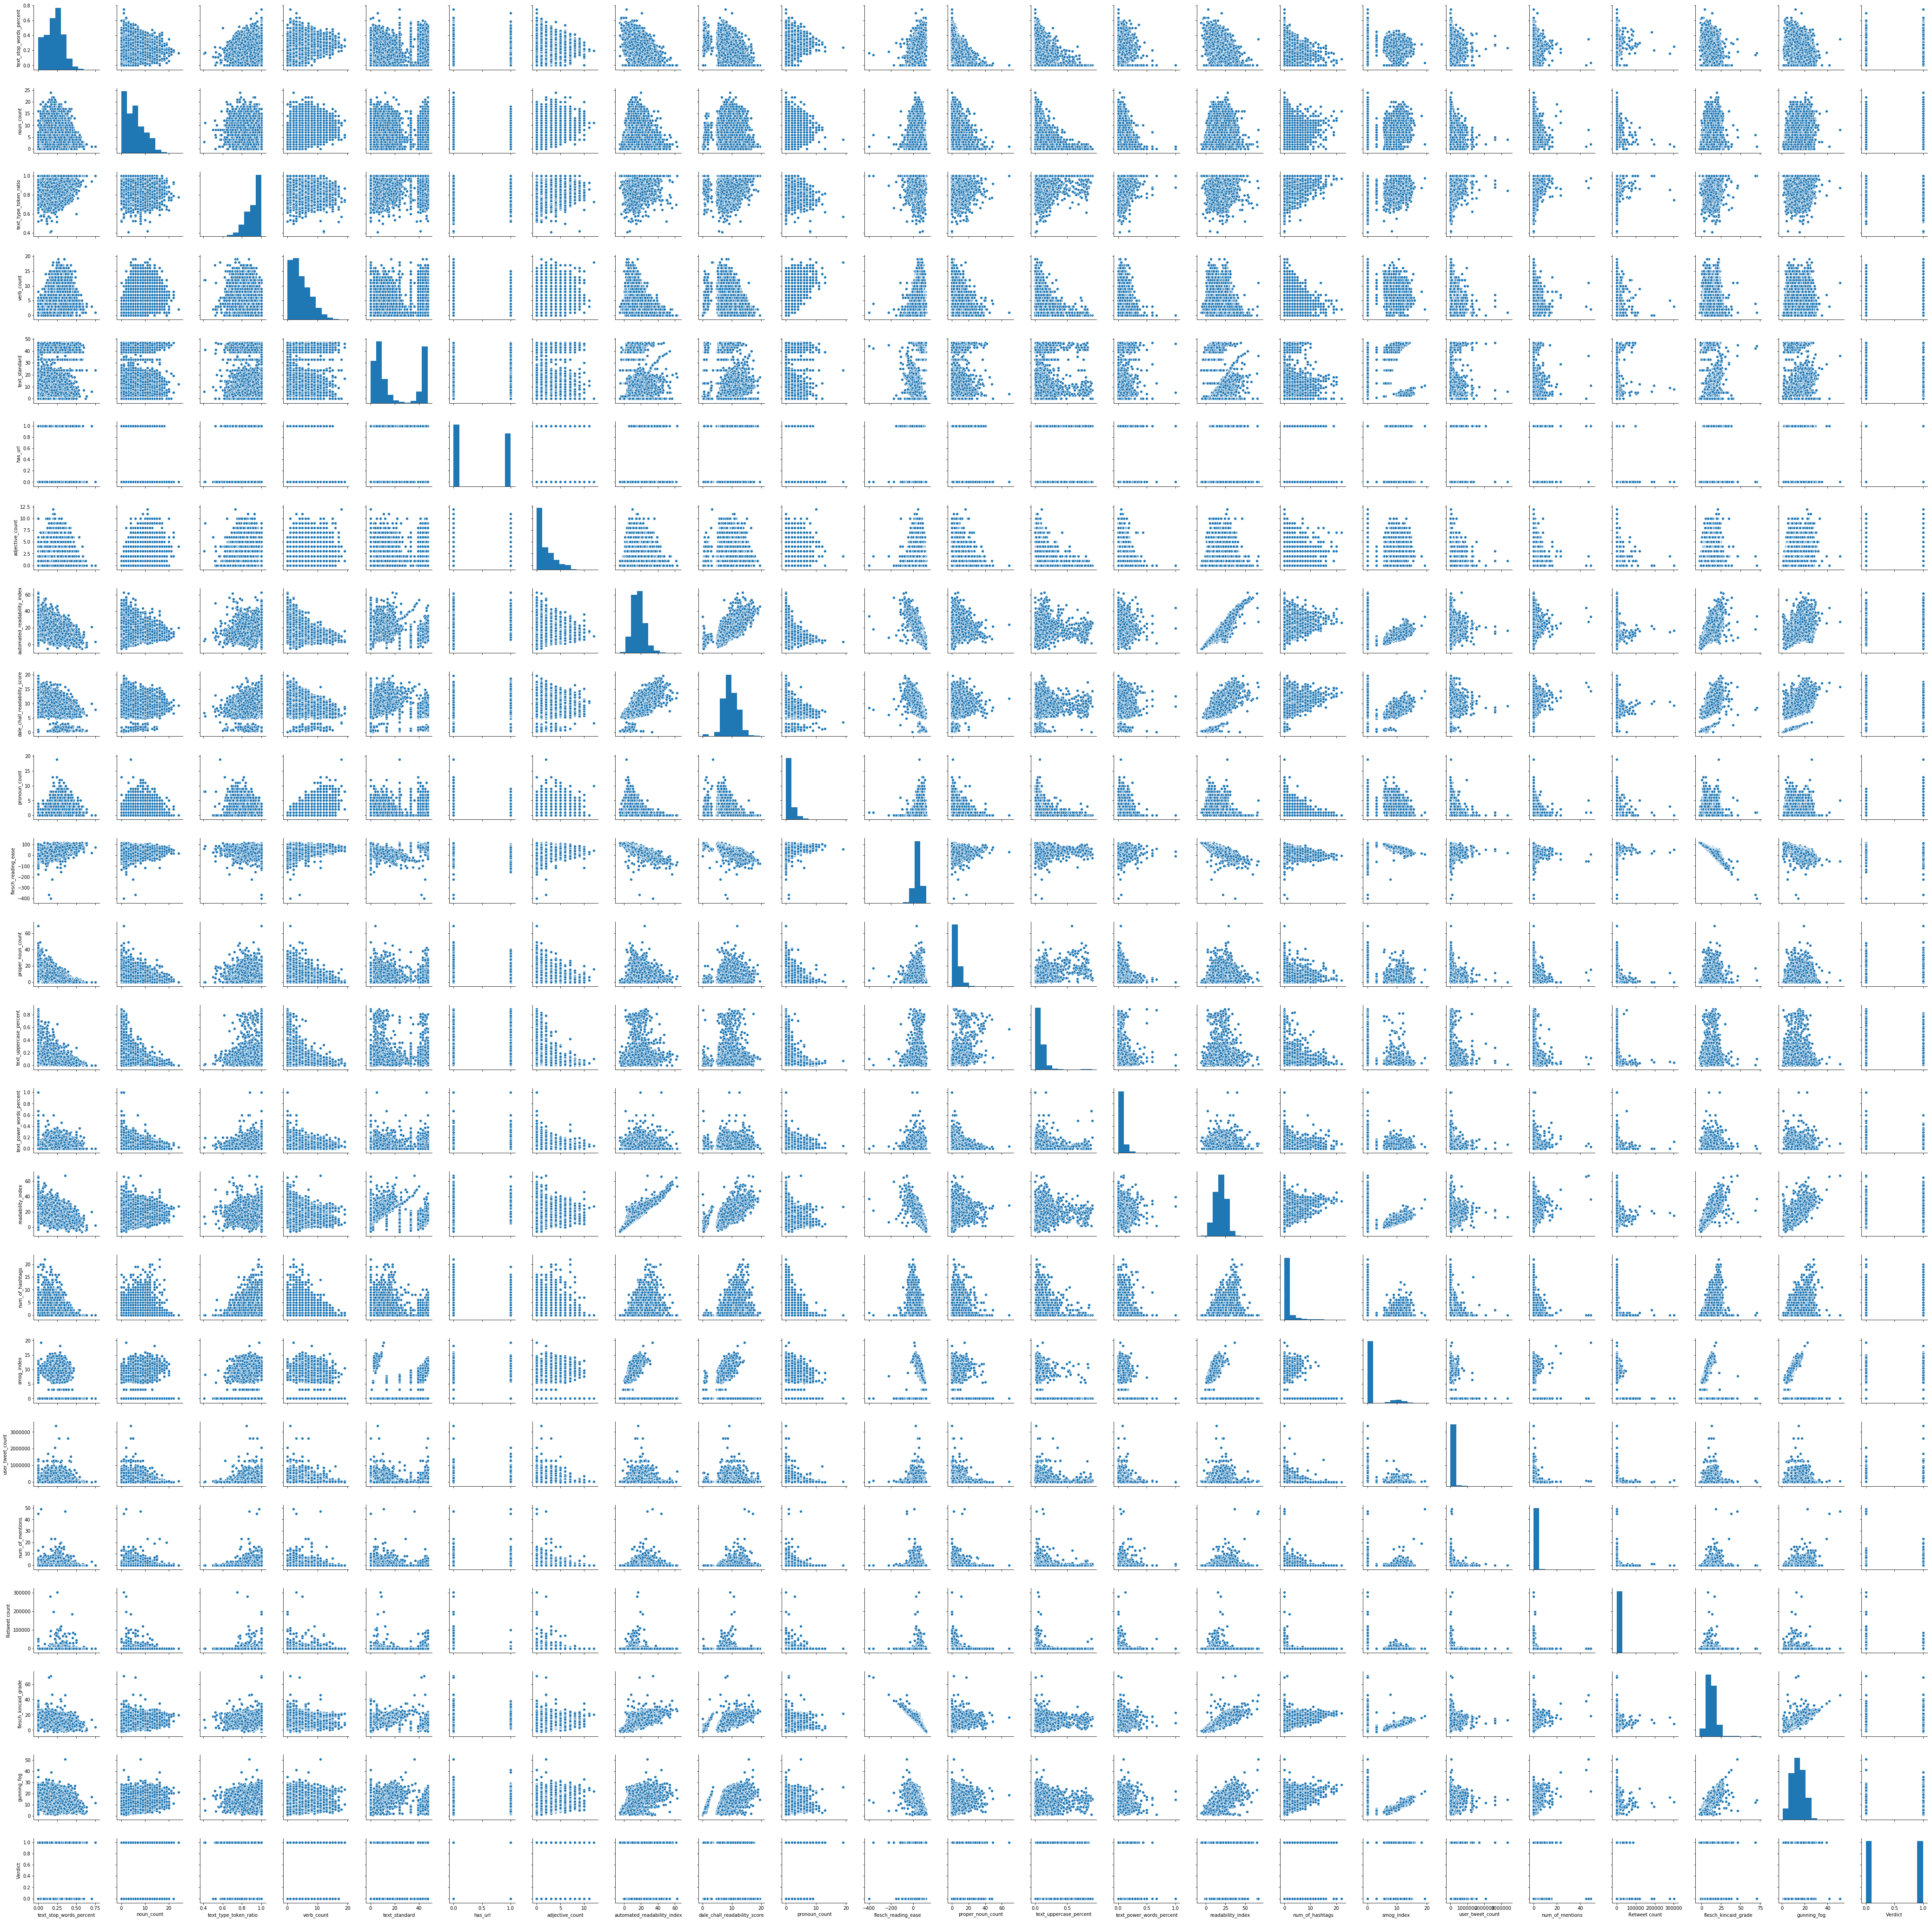

In [91]:
df2 = df[['text_stop_words_percent', 'noun_count', 'text_type_token_ratio', 'verb_count', 'text_standard', 'has_url', 'adjective_count', 'automated_readability_index', 'dale_chall_readability_score', 'pronoun_count', 'flesch_reading_ease', 'proper_noun_count', 'text_uppercase_percent', 'text_power_words_percent', 'readability_index', 'num_of_hashtags', 'smog_index', 'user_tweet_count', 'num_of_mentions', 'Retweet count', 'flesch_kincaid_grade', 'gunning_fog', 'Verdict']]
seaborn.pairplot(df2)

In [134]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [135]:
sc_x = StandardScaler()
x_train = sc_x.fit_transform(x_train)
x_test = sc_x.transform(x_test)

In [117]:
with open('standardScaler_final.pickle', 'wb') as handle:
    pickle.dump(sc_x, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Logistic regression

              precision    recall  f1-score   support

           0       0.77      0.75      0.76      2212
           1       0.76      0.78      0.77      2288

    accuracy                           0.76      4500
   macro avg       0.77      0.76      0.76      4500
weighted avg       0.77      0.76      0.76      4500

Accuracy score: 0.7648888888888888
Precision score: 0.7612574341546304
Recall score: 0.7832167832167832


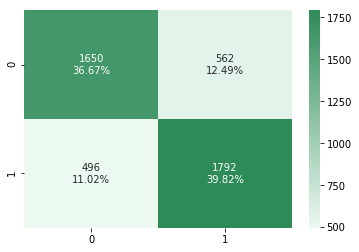

In [118]:
lr = LogisticRegression(random_state = 0, C=500)
lr.fit(x_train, y_train)
y_predict = lr.predict(x_test)

accuracy = evaluate(y_test, y_predict)
confusion_matrix_plot(confusion_matrix(y_test, y_predict))

In [119]:
pkl_filename = "models/logistic_regression.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(lr, file)

### Naive Bayes

              precision    recall  f1-score   support

           0       0.78      0.64      0.70      2212
           1       0.70      0.82      0.76      2288

    accuracy                           0.73      4500
   macro avg       0.74      0.73      0.73      4500
weighted avg       0.74      0.73      0.73      4500

Accuracy score: 0.7342222222222222
Precision score: 0.704954954954955
Recall score: 0.8208041958041958


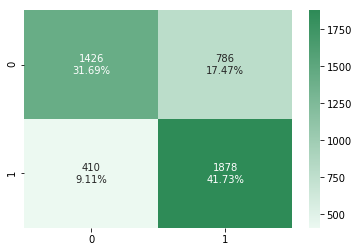

In [120]:
nb = GaussianNB()
nb.fit(x_train, y_train)
y_predict = nb.predict(x_test)

accuracy = evaluate(y_test, y_predict)
confusion_matrix_plot(confusion_matrix(y_test, y_predict))

In [121]:
pkl_filename = "models/naive_bayes.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(nb, file)

### Decision Tree

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      2212
           1       0.83      0.83      0.83      2288

    accuracy                           0.83      4500
   macro avg       0.83      0.83      0.83      4500
weighted avg       0.83      0.83      0.83      4500

Accuracy score: 0.8253333333333334
Precision score: 0.8259548611111112
Recall score: 0.8317307692307693


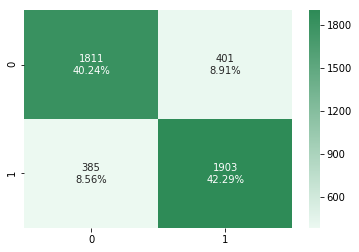

In [22]:
dt = DecisionTreeClassifier(criterion = 'entropy', random_state = 0, max_depth=10, min_samples_split=2, min_samples_leaf=20)
dt.fit(x_train, y_train)
y_predict = dt.predict(x_test)

accuracy = evaluate(y_test, y_predict)
confusion_matrix_plot(confusion_matrix(y_test, y_predict))

In [29]:
pkl_filename = "models/decision_tree.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(dt, file)

### Random forest

              precision    recall  f1-score   support

           0       0.90      0.83      0.87      2212
           1       0.85      0.91      0.88      2288

    accuracy                           0.87      4500
   macro avg       0.87      0.87      0.87      4500
weighted avg       0.87      0.87      0.87      4500

Accuracy score: 0.8724444444444445
Precision score: 0.8500816993464052
Recall score: 0.909527972027972


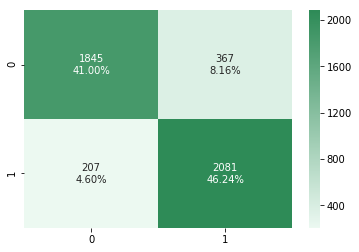

In [138]:
rf = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)
rf.fit(x_train, y_train)
y_predict = rf.predict(x_test)


accuracy = evaluate(y_test, y_predict)
confusion_matrix_plot(confusion_matrix(y_test, y_predict))

In [139]:
pkl_filename = "models/random_forest.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(rf, file)

### SVM

              precision    recall  f1-score   support

           0       0.88      0.77      0.82      2212
           1       0.80      0.90      0.85      2288

    accuracy                           0.84      4500
   macro avg       0.84      0.83      0.83      4500
weighted avg       0.84      0.84      0.83      4500

Accuracy score: 0.8351111111111111
Precision score: 0.7993803253292022
Recall score: 0.9020979020979021


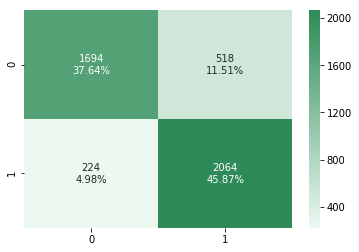

In [17]:
svm = SVC(kernel = 'rbf', gamma='auto', random_state = 0, probability=True, C=10)
svm.fit(x_train, y_train)
prediction_svm = svm.predict(x_test)

accuracy = evaluate(y_test, prediction_svm)
confusion_matrix_plot(confusion_matrix(y_test, prediction_svm))

In [33]:
pkl_filename = "models/svm.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(svm, file)

### KNN

              precision    recall  f1-score   support

           0       0.86      0.76      0.81      2212
           1       0.79      0.88      0.83      2288

    accuracy                           0.82      4500
   macro avg       0.83      0.82      0.82      4500
weighted avg       0.83      0.82      0.82      4500

Accuracy score: 0.8213333333333334
Precision score: 0.7905246671887236
Recall score: 0.8824300699300699


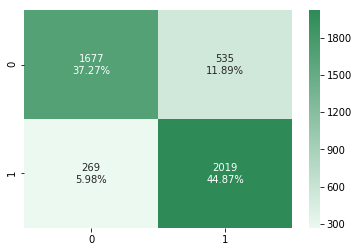

In [91]:
knn = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
knn.fit(x_train, y_train)
y_predict = knn.predict(x_test)

accuracy = evaluate(y_test, y_predict)
confusion_matrix_plot(confusion_matrix(y_test, y_predict))

In [35]:
pkl_filename = "models/knn.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(knn, file)

### Stacking

In [140]:
estimators = [('naive bayes', nb),
              ('svm', svm),
              ('decision tree', dt)]

Stacking = StackingClassifier(estimators=estimators, final_estimator=lr)
Stacking.fit(x_train, y_train)
prediction = Stacking.predict(x_test)

              precision    recall  f1-score   support

           0       0.87      0.79      0.83      2212
           1       0.81      0.89      0.85      2288

    accuracy                           0.84      4500
   macro avg       0.84      0.84      0.84      4500
weighted avg       0.84      0.84      0.84      4500

Accuracy score: 0.8386666666666667
Precision score: 0.8129006410256411
Recall score: 0.8868006993006993


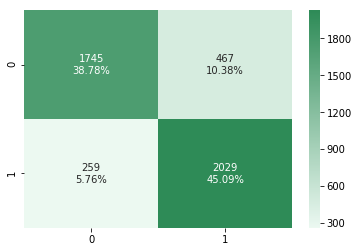

In [141]:
accuracy = evaluate(y_test, prediction)
confusion_matrix_plot(confusion_matrix(y_test, prediction))

### ANN

In [58]:
clear_session()

In [59]:
ann = Sequential()
ann.add(Dense(units = 128, activation = 'relu'))
ann.add(Dropout(0.2))
ann.add(Dense(units = 64, activation = 'relu'))
# ann.add(Dropout(0.2))
ann.add(Dense(units = 1, activation = 'sigmoid'))

ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

my_callbacks = [
    ModelCheckpoint("./saved_models/checkpoints/best_model", monitor='val_accuracy', verbose=1, save_best_only=True),
]

ann.fit(x_train, y_train, validation_data = (x_test, y_test), batch_size = 32, epochs = 100, callbacks = my_callbacks)

Epoch 1/100
422/422 [==============================] - 1s 2ms/step - loss: 0.5481 - accuracy: 0.7218 - val_loss: 0.4586 - val_accuracy: 0.7864

Epoch 00001: val_accuracy improved from -inf to 0.78644, saving model to ./saved_models/checkpoints\best_model
INFO:tensorflow:Assets written to: ./saved_models/checkpoints\best_model\assets
Epoch 2/100
422/422 [==============================] - 1s 2ms/step - loss: 0.4560 - accuracy: 0.7885 - val_loss: 0.4282 - val_accuracy: 0.8080

Epoch 00002: val_accuracy improved from 0.78644 to 0.80800, saving model to ./saved_models/checkpoints\best_model
INFO:tensorflow:Assets written to: ./saved_models/checkpoints\best_model\assets
Epoch 3/100
422/422 [==============================] - 1s 2ms/step - loss: 0.4192 - accuracy: 0.8184 - val_loss: 0.4078 - val_accuracy: 0.8247

Epoch 00003: val_accuracy improved from 0.80800 to 0.82467, saving model to ./saved_models/checkpoints\best_model
INFO:tensorflow:Assets written to: ./saved_models/checkpoints\best_mo


Epoch 00029: val_accuracy did not improve from 0.86356
Epoch 30/100
422/422 [==============================] - 1s 2ms/step - loss: 0.2975 - accuracy: 0.8767 - val_loss: 0.3339 - val_accuracy: 0.8600

Epoch 00030: val_accuracy did not improve from 0.86356
Epoch 31/100
422/422 [==============================] - 1s 2ms/step - loss: 0.2951 - accuracy: 0.8756 - val_loss: 0.3343 - val_accuracy: 0.8613

Epoch 00031: val_accuracy did not improve from 0.86356
Epoch 32/100
422/422 [==============================] - 1s 2ms/step - loss: 0.2888 - accuracy: 0.8830 - val_loss: 0.3308 - val_accuracy: 0.8580

Epoch 00032: val_accuracy did not improve from 0.86356
Epoch 33/100
422/422 [==============================] - 1s 1ms/step - loss: 0.2884 - accuracy: 0.8809 - val_loss: 0.3333 - val_accuracy: 0.8607

Epoch 00033: val_accuracy did not improve from 0.86356
Epoch 34/100
422/422 [==============================] - 1s 1ms/step - loss: 0.2812 - accuracy: 0.8811 - val_loss: 0.3293 - val_accuracy: 0.8631


              precision    recall  f1-score   support

           0       0.90      0.85      0.88      2212
           1       0.87      0.91      0.89      2288

    accuracy                           0.88      4500
   macro avg       0.88      0.88      0.88      4500
weighted avg       0.88      0.88      0.88      4500

Accuracy score: 0.882
Precision score: 0.8652806652806653
Recall score: 0.909527972027972


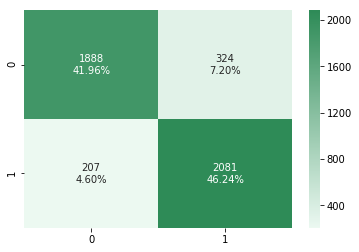

In [88]:
best_model = tf.keras.models.load_model("./saved_models/checkpoints/best_model")
prediction = best_model.predict_classes(x_test)
accuracy = evaluate(y_test, prediction)
confusion_matrix_plot(confusion_matrix(y_test, prediction))
filename = 'ann.h5'
best_model.save('models/' + filename)

In [ ]:
# user_countries = []
# c = 0
# for i in df['user_location']:
#     c += 1
#     user_places = geograpy.get_place_context(text = i)
#     user_countries.append(user_places.countries)
#     print(c)
    


# with open('country.pickle', 'rb') as handle:
#     user_countries = pickle.load(handle)

# df.loc[(df['user_verified']==1) & (df['Verdict']==0)]

In [42]:
# x1 = df.loc[df['Verdict']==1]['adjective_count']
# x2 = df.loc[df['Verdict'] == 0]['adjective_count']

# group_labels = ['TRUE', 'FAKE']

# colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']

# fig = ff.create_distplot(
#     [x1, x2], group_labels,colors=colors)

# fig.update_layout(title_text='Distribution of Stop Words in title', template="plotly_white")
# fig.show()

In [ ]:
# fig = go.Figure()
# fig.add_trace(go.Box(y=x1, name='TRUE',
#                 marker_color = 'rgb(0, 0, 100)'))
# fig.add_trace(go.Box(y=x2, name = 'FAKE',
#                 marker_color = 'rgb(0, 200, 200)'))
# fig.update_layout(title_text='Box plot of Stop Words in title', template="plotly_white")
# fig.show()